In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/a/antonio-costa/BehaviorModel/utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

In [2]:
f = h5py.File('/bucket/StephensU/antonio/npr-1_data/resampled_results.h5','r')
print(list(f.keys()))
frameRate = np.array(f['new_frameRate'])[0]
dt= 1./frameRate
worm_labels = list(f.keys())[1:]
tseries_w=[]
for worm in worm_labels:
    ts = ma.masked_invalid(np.array(f[worm]))
    tseries_w.append(ts)
f.close()


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate=frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

['new_frameRate', 'npr-1 (ad609) on food R_2010_01_26__12_44_18___2___7', 'npr-1 (ad609)X on food  R_2010_01_25__16_08___3___10', 'npr-1 (ad609)X on food L_2010_01_22__11_33_10___2___5', 'npr-1 (ad609)X on food L_2010_01_26__12_44___3___7', 'npr-1 (ad609)X on food R_2010_01_22__11_34_25___8___5', 'npr-1 (ad609)X on food R_2010_01_22__11_35_12__5', 'npr-1 (ad609)X on food R_2010_01_26__12_44_50___4___7']


In [6]:
n_clusters=562
f = h5py.File('/flash/StephensU/antonio/BehaviorModel/npr-1/labels_K_8_N_562.h5','r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
f.close()

labels_traj[mask_traj] = ma.masked

delay=10
ctraj_path = '/flash/StephensU/antonio/BehaviorModel/npr-1/ctrajs_562_clusters_delay_{}/'.format(delay)
f = h5py.File(ctraj_path+'/c_traj.h5','r')
mD = f['MetaData']
n_clusters = np.array(mD['n_clusters'],dtype=int)[0]
delay = np.array(mD['delay'],dtype=int)[0]
ctraj = ma.array(f['ctraj'])
mask = ma.array(f['ctraj_mask'])
ctraj[mask==1] = ma.masked
kmeans_labels = np.array(f['kmeans_labels'])
final_labels = ma.array(f['final_labels'],dtype=int)
final_labels[labels_traj.mask] = ma.masked
f.close()

In [7]:
n_worms = len(tseries_w)
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked
cluster_traj_w = []
ctraj_w = []
t0 = 0
for kw in range(n_worms):
    cluster_traj_w.append(cluster_traj[t0:t0+len(tseries_w[kw])])
    ctraj_w.append(ctraj[t0:t0+len(tseries_w[kw])])
    t0+=len(tseries_w[kw])

In [8]:
def state_lifetime(states):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries)))
    return durations

In [15]:
f = h5py.File('/flash/StephensU/antonio/npr-1/sims/symbol_sequence_simulations_1000_clusters.h5','r')
sims_w=[]
for worm in worm_labels:
    sims = np.array(f[worm]['sims'],dtype=int)
    sims_w.append(sims)
f.close()

In [36]:
# stride = delay
step = int(delay)
dts_w=[]
for kw,X in enumerate(ctraj_w):
    labels = ma.zeros(X.shape,dtype=int)
    labels[X>0] = 1
    labels[X.mask] = ma.masked
    dts = np.array(state_lifetime(labels[::step]))*step*dt
    dts_w.append(np.hstack(dts))

In [29]:
kw=0
dts_sims_w = []
for kw in range(n_worms):
    sims = sims_w[kw]
    dts_sims=[]
    for sim in sims:
        labels_sim = ma.array(kmeans_labels[sim],dtype=int)
        dts_sim = np.array(state_lifetime(labels_sim))*delay*dt
        dts_sims.append(np.hstack(dts_sim))
    dts_sims_w.append(np.hstack(dts_sims))

In [28]:
def get_errorbar_dist(lifetimes_w,t0,tf):
    all_lt = np.hstack(lifetimes_w)
    x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
    y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x_all = np.sort(np.unique(x))
    
    dict_y = {}
    for x_ in x_all:
        dict_y[x_] = []

    for k in range(100):
        x,y = stats.cumulative_dist(np.hstack(np.random.choice(lifetimes_w,len(lifetimes_w))),(t0,tf))
        y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
        x = np.sort(np.unique(x))
        for kx in range(len(y)):
            dict_y[x[kx]].append(y[kx])
        if k%10==0:
            print(k)
            
    y_errorbars = np.zeros((len(dict_y.keys()),3))
    for kx,x_ in enumerate(x_all):
        values = np.array(dict_y[x_])
        values = values[values>0]
        cil = np.percentile(values,2.5)
        ciu = np.percentile(values,97.5)
        y_errorbars[kx] = [y_all[kx],cil,ciu]
    return x_all,y_errorbars

In [30]:
x_sim,y_err_sim = get_errorbar_dist(dts_sims_w,0,5000)

0
10
20
30
40
50
60
70
80
90


In [38]:
x_data,y_err_data = get_errorbar_dist(dts_w,0,5000)

0
10
20
30
40
50
60
70
80
90


In [39]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

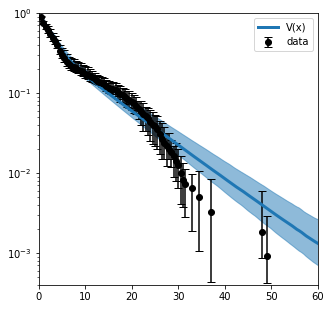

In [40]:
plt.figure(figsize=(5,5))
plt.errorbar(x_data[:-1],y_err_data[:-1,0],yerr = [y_err_data[:-1,0]-y_err_data[:-1,1],y_err_data[:-1,2]-y_err_data[:-1,0]],c='k',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_sim[:-1],y_err_sim[:-1,0],c=colors_state_[0],lw=3,label='V(x)')
plt.fill_between(x_sim[:-1],y_err_sim[:-1,1],y_err_sim[:-1,2],alpha=.5,color=colors_state_[0])
plt.legend()
plt.xlim(0,60)
plt.ylim(4e-4,1)
# trange = np.linspace(0,400)
# plt.plot(trange,5e-2*np.exp(-trange/50),c='k')
# plt.xscale('log')
plt.yscale('log')
# plt.savefig('fpt_V(x,t)_fish.pdf')
plt.show()